## Precisión (precision) vs cobertura/sensibilidad (recall/sensitivity)

Definiciones:

Precisión: Total de verdaderos positivos diagnosticados por el modelo de prueba (prueba rápida en el ejemplo del virus SARS-Cov2) dividido entre el total de observaciones (individuos) clasificadas (diagnosticados) como positivas por el modelo de prueba.

Cobertura/Sensibilidad: Total de verdaderos positivos diagnosticados por el modelo de prueba respecto al total de observaciones clasificadas como positivas mediante el modelo de entrenamiento (técnica de PCR en el caso del ejemplo del virus SARS-Cov2 o Gold Standard). También se le conoce como sensibilidad.

La siguiente imagen busca esquematizar ambos conceptos, ésta fue tomada de: https://commons.wikimedia.org/wiki/File:Precisionrecall.svg

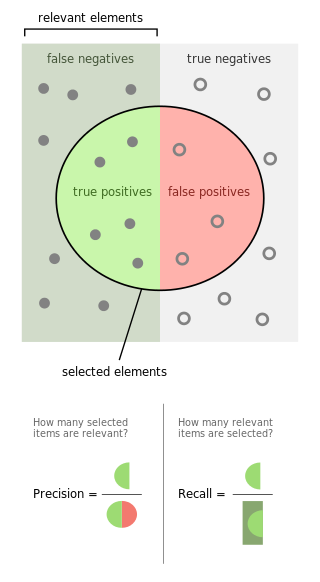

A continuación realizaremos un ejemplo para abordar ambos conceptos a partir de un conjunto de datos de pacientes que tienen una enfermedad cardiaca. La prueba diagnóstica o en otras palabras, el algoritmo clasificatorio que pondremos a prueba será K-Nearest-Neighbors (KNN), dicho algoritmo no será abordado en este momento pero nos servirá para contrastar estas dos métricas de evaluación (así como otras) y entender por qué son útiles para evaluar la calidad de un modelo clasificatorio.

In [3]:
# Loading modules
import numpy as np
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Loading dataset
datos = pd.read_csv("heart.csv")# Download your dataset from here https://www.kaggle.com/ronitf/heart-disease-uci
datos.isnull().sum()# Checking for null elements in observations
datos# Verifying the total "N" of the dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


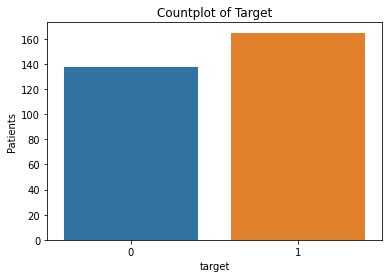

In [5]:
# Checking how many patients have the condition and how many not
sns.countplot(datos['target'])
# Add labels
plt.title('Countplot of Target')
plt.xlabel('target')
plt.ylabel('Patients')
plt.show()

In [6]:
# Separating dataset into Target and Input variables
y = datos["target"].values # Target variable, dependent variable.
x = datos.drop(["target"], axis = 1) # Input variables, independent variables.

#Scaling - mandatory for knn
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x = ss.fit_transform(x)

#SPlitting into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) # 70% training and 30%

Un aspecto que aún no heos tratado es ¿cómo determinar la K óptima para un algoritmo clasificatorio?, existen varios criterios, sin embargo, los abordaremos en clases posteriores. De momento sepamos que dicho valor puede ser determinado a partir de un "test score" o puntaje de prueba calculado para varios valores de K, y en consecuencia el valor más alto nos indicará que número de grupos o "clusters" (K) es el adecuado.

Para este ejemplo usaremos el valor de K = 3 para construir nuestro clasificador.

In [7]:
#Setup a knn classifier with k=3 neighbors
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))
knn.fit(X_train, y_train)

0.8351648351648352


KNeighborsClassifier(n_neighbors=3)

Ahora bien, ¿cómo evaluamos si el desempeño del clasificador es bueno o malo?

Pues utilizando nuestras métricas de evaluación y para obtenerlas tenemos que construir nuestra matriz de confusión:

In [10]:
# Building confussion matrix
y_pred = knn.predict(X_test)
print(y_pred)
confusion_matrix(y_pred,y_test)
pd.crosstab(y_pred, y_test, rownames = ['Predicted'], colnames = ['Actual'], margins = True)

[0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1]


Actual,0,1,All
Predicted,,,
0,28,8,36
1,7,48,55
All,35,56,91


## Ejercicio y definición de Exactitud (Accuracy) :

Calcula a partir de la matriz anterior los valores de Precisión (Precision), Sensibilidad o Cobertura (Recall) y el valor de Exactitud (Accuracy). Para esto puedes consultar el material que previamente se te compartió en donde viene la definición de Exactitud (o si no consulta wikipedia). Una vez calculados estos valores, ponte en la posición de un médico que debe de tomar una decisión en función de estas medidas y discute brevemente qué sería mejor en el caso que estamos abordando:
 1. ¿Que la prueba detecte más a los verdaderos positivos (alta Sensibilidad)? y/o ¿que de los positivos que detecte la prueba se tengan pocos falsos positivos (alta Precisión)?
 2. ¿Con base en el ejemplo anterior, podría ocurrir un caso hipotético en el que tuvieras un alto valor de Exactitud y un bajo valor de Precisión y/o un bajo valor de Sensibilidad? En función de tu respuesta da un ejemplo de matriz de confusión que la soporte o argumenta por qué no puede darse un ejemplo así.

In [11]:
# print(classification_report(y_test, y_pred)) Exercice correct calculations.

## Definición de valor de F1 (F1-score) :

A partir de la pregunta 2 te darás cuenta de que se pueden tener varios casos en cuanto a las métricas de evaluación para una prueba clasificatoria o clasificador. Hablaremos también de una métrica de evaluación que busca ponderar la calidad de la Precisión y la de la Sensibilidad, ya que existen ocasiones en que nos gustaría que ambas métricas fueran lo más altas posibles. Esto se logra a partir de la optimización del llamado valor de F1 (F1-score) el cual se define como la media armónica entre la Precisión y la Sensibilidad.

$F1-score=$ ${Precisión~*~Sensibilidad} \over {Precisión~+~Sensibilidad}$

## Curva ROC (Receiver Operating Characteristic): 

Se trata de un gráfico bidimensional que en el caso de un clasificador binario (clasificador de dos categoría) muestra en el Eje-Y la Tasa de Verdaderos Positivos (True Positive Rate o TPR) contra la la Tasa de Falsos Positivos (False Positive Rate o FPR) en el Eje-X. Es importante mencionar que la Tasa de Verdaderos Positivos es otra manera de llamar a la Sensibilidad, también conocida como Cobertura o como Recall, mientras que la Tasa de Falsos Positivos recordemos que también es conocida como Valor-P en estadística y son todos aquellos individuos u observaciones en donde se cometió un error de Tipo 1, esta segunda tasa puede calcularse como 1-Especificidad, la cual es conocida como Tasa de Verdaderos Negativos o True Negative Rate).

Sin embargo, dado el ejemplo anterior sólo tenemos un valor de TPR y uno de FPR, ¿cómo podemos entonces generar una curva o en otras palabras, más parejas de estos valores para graficarlos en dos dimensiones?

Para responder lo anterior debemos notar algo, nosotros ya generamos un modelo clasificatorio con KNN para el dataset de enfermedades cardiácas. Dicho modelo "decide" si una observación del conjunto de prueba pertenece o no a una categoría a partir de una cierta probabilidad, éste valor se fija por convención en 0.5, por lo tanto si la probabilidad de que la observación pertenezca a una categoría supera dicho valor dicha observación será clasificada dentro de la categoría y viceversa. Esto no impide que modifiquemos el valor de dicho umbral y por lo tanto que seamos capaces de generar distintos valores de TPR y FPR para distintos valores del umbral de clasificación, que en consecuencia ahora sí podremos graficar como una curva y analizarla.

Considerando esto generemos una curva ROC para nuestro clasificador con k=3:

[0.         0.         0.33333333 0.         0.33333333 0.
 0.66666667 1.         1.         0.         1.         1.
 0.         0.33333333 0.66666667 0.         1.         0.
 0.66666667 0.33333333 0.66666667 0.33333333 0.33333333 1.
 1.         0.33333333 1.         0.33333333 1.         1.
 1.         0.66666667 0.33333333 0.33333333 1.         0.66666667
 0.66666667 0.         0.66666667 1.         0.66666667 0.66666667
 0.         1.         0.66666667 0.33333333 1.         1.
 0.33333333 0.66666667 0.66666667 0.66666667 0.         0.66666667
 1.         0.33333333 1.         0.33333333 1.         0.66666667
 0.         0.33333333 0.66666667 1.         1.         1.
 0.66666667 1.         1.         0.66666667 1.         1.
 0.33333333 1.         0.         0.33333333 0.66666667 0.66666667
 0.33333333 0.33333333 1.         0.         1.         0.66666667
 0.33333333 1.         0.33333333 0.         1.         0.66666667
 1.        ]
[2.         1.         0.66666667 0.33333333 0

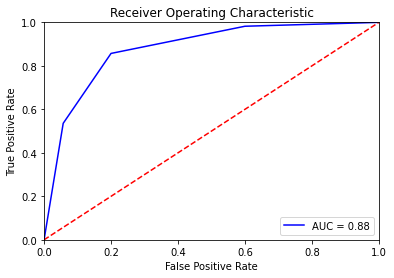

In [13]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
print(y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)# Generating
print(thresholds)
roc_auc = roc_auc_score(y_test, y_pred_proba)# Calculating Area Under the Curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
exp_clf = setup(datos, target = 'target')

,Description,Value
0,session_id,1861
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(303, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8541,0.9091,0.8705,0.8703,0.8660,0.7039,0.7126,2.6030
ridge,Ridge Classifier,0.8496,0.0000,0.8788,0.8549,0.8636,0.6941,0.7015,0.0330
lda,Linear Discriminant Analysis,0.8496,0.9048,0.8795,0.8553,0.8644,0.6940,0.7003,0.0310
nb,Naive Bayes,0.8446,0.8877,0.8712,0.8519,0.8592,0.6845,0.6892,0.0310
gbc,Gradient Boosting Classifier,0.8017,0.8784,0.8439,0.8115,0.8230,0.5959,0.6052,0.1550
et,Extra Trees Classifier,0.7970,0.8781,0.8432,0.7990,0.8173,0.5875,0.5977,0.2840
rf,Random Forest Classifier,0.7831,0.8790,0.8182,0.7998,0.8057,0.5577,0.5649,0.3110
ada,Ada Boost Classifier,0.7781,0.8404,0.8182,0.7910,0.7981,0.5479,0.5589,0.1930
lightgbm,Light Gradient Boosting Machine,0.7779,0.8684,0.8091,0.7975,0.7980,0.5480,0.5569,0.0700
dt,Decision Tree Classifier,0.7214,0.7202,0.7326,0.7538,0.7396,0.4393,0.4434,0.0200


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1861, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
lr = create_model('lr')
# tune hyperparameters of decision tree
tuned_et = tune_model(lr, n_iter = 50, optimize = 'recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7727,0.8750,0.7500,0.8182,0.7826,0.5455,0.5477
1,0.9545,0.9833,1.0000,0.9231,0.9600,0.9076,0.9115
2,0.8095,0.8364,0.8182,0.8182,0.8182,0.6182,0.6182
3,0.9524,0.9909,1.0000,0.9167,0.9565,0.9041,0.9083
4,0.8095,0.9545,0.8182,0.8182,0.8182,0.6182,0.6182
5,0.8571,0.8636,0.9091,0.8333,0.8696,0.7123,0.7156
6,0.6667,0.8056,0.8333,0.6667,0.7407,0.2899,0.3043
7,0.9048,0.9444,1.0000,0.8571,0.9231,0.8000,0.8165
8,0.9048,0.9259,0.9167,0.9167,0.9167,0.8056,0.8056
9,0.9048,0.9074,0.8333,1.0000,0.9091,0.8108,0.8257
